## Emotion Detection in Text

**Group 13**  
Temirlan Yeslamov, Zholdas Aldanbergen, Azamat Galidenov, Aleksandr Nikonorov

**Brief Description:**  
Detect emotions in tweets using an LSTM or Transformer model.

**Motivation:**  
Analyze online sentiment, e.g., in social media or crisis communication.

**Interesting Aspects:**  
- Introduction to natural language processing  
- Discussable language bias  
- Interesting visualization possible

**Dataset:**  
[Emotions Dataset for NLP - Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)

**Supervisor:**  
Prof. Dr. Florian Wahl (AI, THD)

## Installing dependencies

In [ ]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Download Pre-trained Word2Vec

In [2]:
%pip install gensim tqdm

import gensim.downloader as api
#  Google News 300
word2vec = api.load('word2vec-google-news-300')
print("Word2Vec loaded.")



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Word2Vec loaded.


In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import string
from IPython.display import clear_output
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns # For enhanced visualizations
import re
import os
import json
import time
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from typing import List, Tuple, Dict, Optional, Any, Set
from tensorflow.keras.layers import Bidirectional, LSTM, Attention, GlobalAveragePooling1D
from collections import Counter # For class distribution
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

## Data

### Load data

In [22]:
DATA_PATH_TRAIN = "data/train.txt"
DATA_PATH_TEST = "data/test.txt"
DATA_PATH_VAL = "data/val.txt"

df_train = pd.read_csv(DATA_PATH_TRAIN, delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv(DATA_PATH_TEST, delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv(DATA_PATH_VAL, delimiter=';', header=None, names=['sentence','label'])

print("\nTrain set label distribution:")
print(df_train['label'].value_counts(normalize=True)*100)
print("\nValidation set label distribution:")
print(df_val['label'].value_counts(normalize=True)*100)
print("\nTest set label distribution:")
print(df_test['label'].value_counts(normalize=True)*100)


Train set label distribution:
label
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: proportion, dtype: float64

Validation set label distribution:
label
joy         34.75
sadness     29.05
anger       13.75
fear        11.20
love         7.95
surprise     3.30
Name: proportion, dtype: float64

Test set label distribution:
label
joy         35.20
sadness     27.50
anger       13.75
fear        10.60
love         8.90
surprise     4.05
Name: proportion, dtype: float64


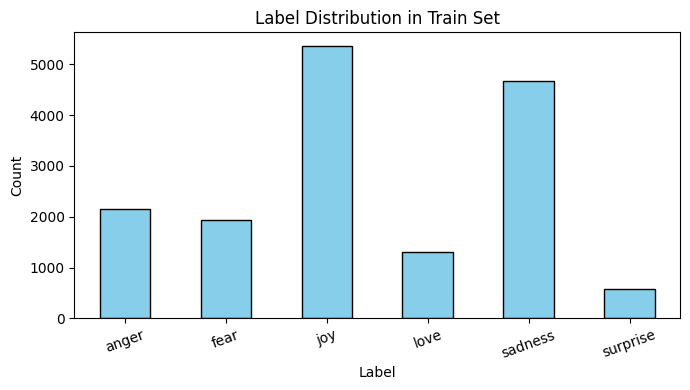

In [23]:
label_counts = df_train['label'].value_counts().sort_index()

plt.figure(figsize=(7, 4))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train Set')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

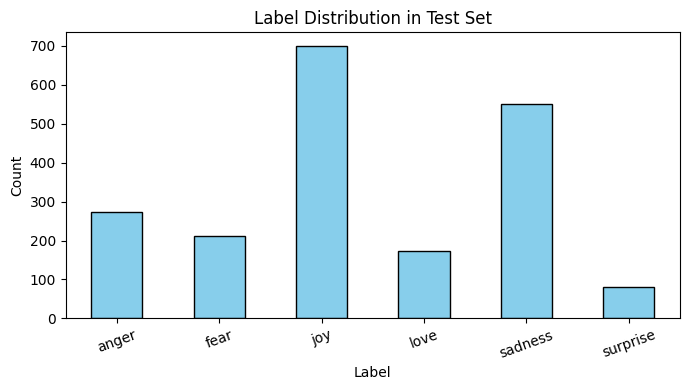

In [44]:
label_counts = df_test['label'].value_counts().sort_index()

plt.figure(figsize=(7, 4))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Test Set')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

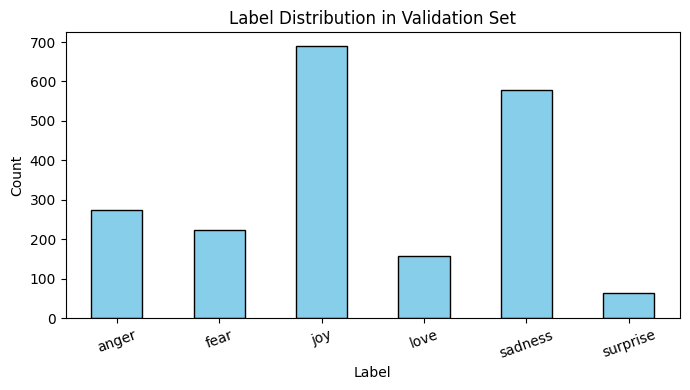

In [45]:
label_counts = df_val['label'].value_counts().sort_index()

plt.figure(figsize=(7, 4))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Validation Set')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

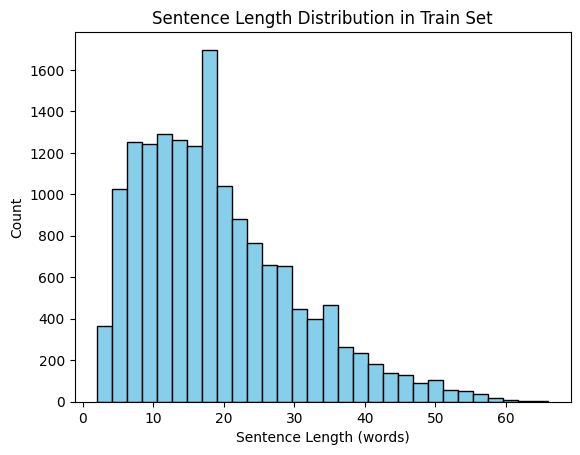

In [25]:
sentence_lengths = df_train['sentence'].apply(lambda x: len(x.split()))
plt.hist(sentence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Count')
plt.title('Sentence Length Distribution in Train Set')
plt.show()

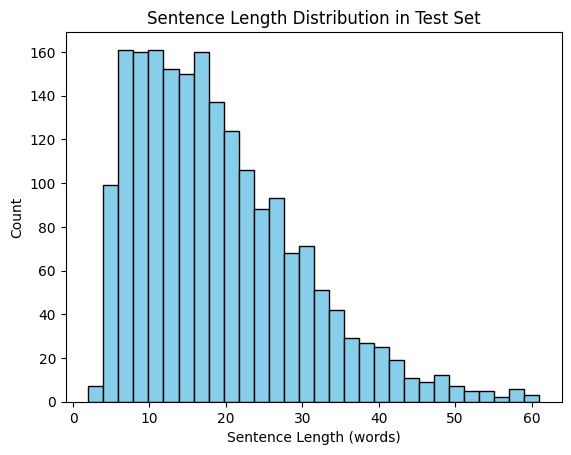

In [46]:
sentence_lengths = df_test['sentence'].apply(lambda x: len(x.split()))
plt.hist(sentence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Count')
plt.title('Sentence Length Distribution in Test Set')
plt.show()

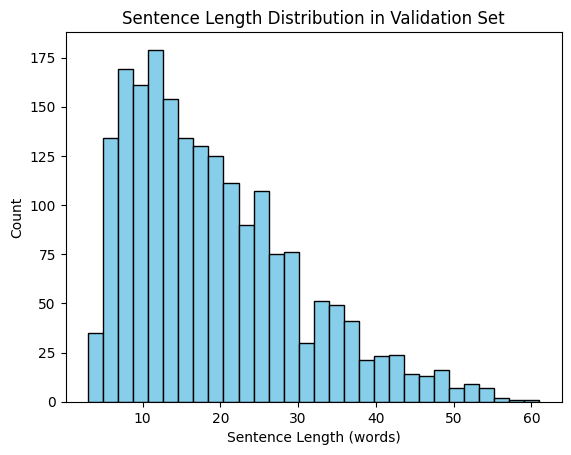

In [47]:
sentence_lengths = df_val['sentence'].apply(lambda x: len(x.split()))
plt.hist(sentence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Count')
plt.title('Sentence Length Distribution in Validation Set')
plt.show()

In [5]:
df_train.describe()

,sentence,label
count,15970,15970
unique,15969,6
top,i feel more adventurous willing to take risks ...,joy
freq,2,5346


In [6]:
df_test.describe()

,sentence,label
count,1993,1993
unique,1993,6
top,im feeling quite sad and sorry for myself but ...,joy
freq,1,701


In [7]:
df_val.describe()

,sentence,label
count,1986,1986
unique,1986,6
top,im feeling rather rotten so im not very ambiti...,joy
freq,1,688


In [8]:
df_train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Preprocessing

In [28]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = remove_punctuation(text)
    return text

print("Applying text cleaning...")
df_train['sentence'] = df_train['sentence'].apply(clean_text)
df_val['sentence'] = df_val['sentence'].apply(clean_text)
df_test['sentence'] = df_test['sentence'].apply(clean_text)
print("Text cleaning complete.")

Applying text cleaning...
Text cleaning complete.


In [29]:
# Check for duplicates
datasets = {'train': df_train, 'validation': df_val, 'test': df_test}

for name, df in datasets.items():
    print(f"\n--- {name.upper()} SET ---")
    print("NaN counts per column:")
    print(df.isna().sum())
    print(f"Number of duplicate rows (all columns): {df.duplicated().sum()}")
    print(f"Number of duplicate sentences (ignore label): {df.duplicated(subset=['sentence']).sum()}")
    if df.duplicated(subset=['sentence']).sum() > 0:
        print("Duplicate sentences (showing first 5):")
        print(df[df.duplicated(subset=['sentence'])].head())


--- TRAIN SET ---
NaN counts per column:
sentence    0
label       0
dtype: int64
Number of duplicate rows (all columns): 1
Number of duplicate sentences (ignore label): 31
Duplicate sentences (showing first 5):
                                               sentence     label
5067  i feel on the verge of tears from weariness i ...       joy
6133              i still feel a craving for sweet food      love
6563  i tend to stop breathing when i m feeling stre...     anger
7623  i was intensely conscious of how much cash i h...   sadness
7685  im still not sure why reilly feels the need to...  surprise

--- VALIDATION SET ---
NaN counts per column:
sentence    0
label       0
dtype: int64
Number of duplicate rows (all columns): 0
Number of duplicate sentences (ignore label): 0

--- TEST SET ---
NaN counts per column:
sentence    0
label       0
dtype: int64
Number of duplicate rows (all columns): 0
Number of duplicate sentences (ignore label): 2
Duplicate sentences (showing first 5):
  

In [30]:
# Find all sentences that occur more than once, regardless of label
dup_sentences = df_train[df_train.duplicated(subset=['sentence'], keep=False)]

print(dup_sentences.sort_values('sentence'))

                                                sentence     label
8246   i am not amazing or great at photography but i...      love
3508   i am not amazing or great at photography but i...       joy
15705  i began to feel accepted by gaia on her own terms       joy
5277   i began to feel accepted by gaia on her own terms      love
8804   i bet taylor swift basks in the knowledge that...      fear
...                                                  ...       ...
11354  i write these words i feel sweet baby kicks fr...      love
7685   im still not sure why reilly feels the need to...  surprise
2908   im still not sure why reilly feels the need to...      fear
9596   ive also made it with both sugar measurements ...       joy
9069   ive also made it with both sugar measurements ...      love

[62 rows x 2 columns]


In [31]:
# Dropping duplicates in train
train_label_counts = df_train['label'].value_counts()

# Identify sentences in train that appear with >1 label
dup_conflict = df_train.groupby('sentence')['label'].nunique()
conflict_sentences = dup_conflict[dup_conflict > 1].index

# For each conflicting sentence, drop the oversampled label
drop_indices = []
for s in conflict_sentences:
    group = df_train[df_train['sentence'] == s]
    # If more than 2 labels for this sentence, just keep the least common
    label_counts_in_group = group['label'].map(lambda lbl: train_label_counts[lbl])
    max_count = label_counts_in_group.max()
    oversampled_labels = group[label_counts_in_group == max_count]['label'].unique()
    to_drop = group[group['label'].isin(oversampled_labels)].index[0]
    drop_indices.append(to_drop)

df_train = df_train.drop(drop_indices).reset_index(drop=True)
print(f"Dropped {len(drop_indices)}")

Dropped 30


In [32]:
# Dropping duplicates in val dataset
val_label_counts = df_val['label'].value_counts()
dup_conflict_val = df_val.groupby('sentence')['label'].nunique()
conflict_sentences_val = dup_conflict_val[dup_conflict_val > 1].index

drop_indices_val = []
for s in conflict_sentences_val:
    group = df_val[df_val['sentence'] == s]
    label_counts_in_group = group['label'].map(lambda lbl: val_label_counts[lbl])
    max_count = label_counts_in_group.max()
    oversampled_labels = group[label_counts_in_group == max_count]['label'].unique()
    to_drop = group[group['label'].isin(oversampled_labels)].index[0]
    drop_indices_val.append(to_drop)

df_val = df_val.drop(drop_indices_val).reset_index(drop=True)
print(f"Dropped {len(drop_indices_val)} conflicting label duplicates from val set.")


Dropped 0 conflicting label duplicates from val set.


In [33]:
# Dropping duplicates in test dataset
test_label_counts = df_test['label'].value_counts()
dup_conflict_test = df_test.groupby('sentence')['label'].nunique()
conflict_sentences_test = dup_conflict_test[dup_conflict_test > 1].index

drop_indices_test = []
for s in conflict_sentences_test:
    group = df_test[df_test['sentence'] == s]
    label_counts_in_group = group['label'].map(lambda lbl: test_label_counts[lbl])
    max_count = label_counts_in_group.max()
    oversampled_labels = group[label_counts_in_group == max_count]['label'].unique()
    to_drop = group[group['label'].isin(oversampled_labels)].index[0]
    drop_indices_test.append(to_drop)

df_test = df_test.drop(drop_indices_test).reset_index(drop=True)
print(f"Dropped {len(drop_indices_test)} conflicting label duplicates from test set.")


Dropped 2 conflicting label duplicates from test set.


In [34]:
# Get unique sentences for each split
train_sentences = set(df_train['sentence'])
val_sentences = set(df_val['sentence'])
test_sentences = set(df_test['sentence'])

# Find overlap between test and train
test_in_train = test_sentences & train_sentences
print(f"Sentences in both test and train: {len(test_in_train)}")
if test_in_train:
    print("Example overlap with train:", list(test_in_train)[:5])

# Find overlap between test and validation
test_in_val = test_sentences & val_sentences
print(f"Sentences in both test and validation: {len(test_in_val)}")
if test_in_val:
    print("Example overlap with validation:", list(test_in_val)[:5])

# Find overlap with both train and validation
test_in_both = test_sentences & (train_sentences | val_sentences)
print(f"Sentences in test also in train or validation: {len(test_in_both)}")
if test_in_both:
    print("Example overlap:", list(test_in_both)[:5])


Sentences in both test and train: 5
Example overlap with train: ['i feel completely blessed to be a part of this group', 'i feel that being faithful isnt enough in your eyes', 'i honestly feel at heart we should be faithful to each other if its yo girl', 'i feel so blessed to be a part of your days', 'i miss our talks our cuddling our kissing and the feelings that you can only share with your beloved']
Sentences in both test and validation: 3
Example overlap with validation: ['i don t always feel like i have amazing style and most days i choose comfort over anything else but there is one thing that i feel makes all the difference in how i feel about myself and that is makeup', 'i feel not having a generous spirit or a forgiving nature closes me off from accepting gifts from the universe', 'i feel like i am in paradise kissing those sweet lips make me feel like i dive into a magical world of love']
Sentences in test also in train or validation: 8
Example overlap: ['i feel completely ble

In [35]:
# Remove overlap: ensuring test sentences do NOT appear in train or val
train_sentences = set(df_train['sentence'])
val_sentences = set(df_val['sentence'])
test_sentences = set(df_test['sentence'])

# Remove from validation any sentence that is in train
val_overlap = val_sentences & train_sentences
df_val_cleaned = df_val[~df_val['sentence'].isin(train_sentences)].reset_index(drop=True)

# Remove from test any sentence that is in train or val
test_overlap = test_sentences & (train_sentences | val_sentences)
df_test_cleaned = df_test[~df_test['sentence'].isin(train_sentences | val_sentences)].reset_index(drop=True)

print(f"Original validation size: {len(df_val)}; Cleaned: {len(df_val_cleaned)}; Removed: {len(df_val) - len(df_val_cleaned)}")
print(f"Original test size: {len(df_test)}; Cleaned: {len(df_test_cleaned)}; Removed: {len(df_test) - len(df_test_cleaned)}")

df_val = df_val_cleaned
df_test = df_test_cleaned


Original validation size: 2000; Cleaned: 1989; Removed: 11
Original test size: 1998; Cleaned: 1990; Removed: 8


In [36]:
CLEAN_DIR = 'data/'

df_train.to_csv(f"{CLEAN_DIR}/train_cleaned.txt", sep=';', index=False, header=False)
df_val.to_csv(f"{CLEAN_DIR}/val_cleaned.txt", sep=';', index=False, header=False)
df_test.to_csv(f"{CLEAN_DIR}/test_cleaned.txt", sep=';', index=False, header=False)

In [37]:
# Loading cleaned dataset before training
df_train = pd.read_csv(f"{CLEAN_DIR}/train_cleaned.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv(f"{CLEAN_DIR}/test_cleaned.txt", delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv(f"{CLEAN_DIR}/val_cleaned.txt", delimiter=';', header=None, names=['sentence','label'])
print("Datasets loaded.")

Datasets loaded.


### Encoding Labels & Preparing Vocab

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_val['label'] = label_encoder.transform(df_val['label'])
df_test['label'] = label_encoder.transform(df_test['label'])

# Build vocabulary from training data
vocab = set(word for sent in df_train['sentence'] for word in sent.split() if word in word2vec)
word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1
idx2word = {idx: word for word, idx in word2idx.items()}

### Encoding sentences

In [10]:
MAX_LEN = 256

def encode_sentence(sentence, max_len=MAX_LEN):
    tokens = sentence.split()
    encoded = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    if len(encoded) < max_len:
        encoded += [word2idx['<PAD>']] * (max_len - len(encoded))
    return encoded[:max_len]


### Dataset and Dataloader setup

In [16]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe):
        self.sentences = [encode_sentence(x) for x in dataframe['sentence']]
        self.labels = dataframe['label'].tolist()

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx]), torch.tensor(self.labels[idx])

BATCH_SIZE = 32

train_loader = DataLoader(EmotionDataset(df_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(EmotionDataset(df_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(EmotionDataset(df_test), batch_size=BATCH_SIZE)

### Embedding Matrix from Word2Vec

In [12]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word2idx), EMBEDDING_DIM))

for word, idx in word2idx.items():
    if word in word2vec:
        embedding_matrix[idx] = word2vec[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))

## Model

In [39]:
class BiLSTMEmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, embeddings):
        super(BiLSTMEmotionClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embeddings, 
                                                                   dtype=torch.float32), 
                                                                   freeze=False)
        self.lstm = nn.LSTM(embed_dim, 
                            hidden_dim, 
                            batch_first=True, 
                            bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        x = self.dropout(hidden)
        return self.fc(x)

NUM_LABELS = 6
model = BiLSTMEmotionClassifier(len(word2idx), 
                                EMBEDDING_DIM, 
                                128, 
                                NUM_LABELS, 
                                embedding_matrix)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Train

In [40]:
EPOCHS = 10
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 3

PLOTS_DIR = './plots'
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

MODEL_SAVE_PATH = './best_emotion_classifier_model.pth'
CHECKPOINT_DIR = './checkpoints' 
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMEmotionClassifier(
    vocab_size=len(word2idx),
    embed_dim=EMBEDDING_DIM,
    hidden_dim=128,
    output_dim=NUM_LABELS,
    embeddings=embedding_matrix
)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2,
)

# Training loop
best_val_loss = float('inf')
early_stop_counter = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_epoch = 0
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']
    best_val_loss = checkpoint['best_val_loss']
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed from checkpoint at epoch {start_epoch}")

for epoch in range(start_epoch, EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Create tqdm with total batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        avg_loss = total_loss / total
        accuracy = correct / total

        # Update tqdm postfix with live stats
        pbar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'acc': f'{accuracy:.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })

    avg_train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    
    tqdm.write(
        f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
        f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}, LR = {current_lr:.6f}"
    )

    # Early stopping & checkpoint saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        tqdm.write("Saved best model.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLY_STOPPING_PATIENCE:
            tqdm.write("Early stopping triggered.")
            break

    torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/epoch_{epoch+1}.pth")

    checkpoint_data = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'best_val_loss': best_val_loss,
    }
    torch.save(checkpoint_data, checkpoint_path)

plt.figure(figsize=(12, 5))

Resumed from checkpoint at epoch 7


Epoch 8/10: 100%|██████████| 500/500 [01:15<00:00,  6.62it/s, loss=0.0402, acc=0.9869, lr=0.000500]


Epoch 8: Train Loss = 0.0402, Train Acc = 0.9869, Val Loss = 0.3062, Val Acc = 0.9164, LR = 0.000500


Epoch 9/10: 100%|██████████| 500/500 [01:18<00:00,  6.34it/s, loss=0.0371, acc=0.9887, lr=0.000500]


Epoch 9: Train Loss = 0.0371, Train Acc = 0.9887, Val Loss = 0.3116, Val Acc = 0.9154, LR = 0.000500


Epoch 10/10: 100%|██████████| 500/500 [01:18<00:00,  6.35it/s, loss=0.0545, acc=0.9828, lr=0.000500]


Epoch 10: Train Loss = 0.0545, Train Acc = 0.9828, Val Loss = 0.3087, Val Acc = 0.9094, LR = 0.000500
Early stopping triggered.


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

## Evaluation

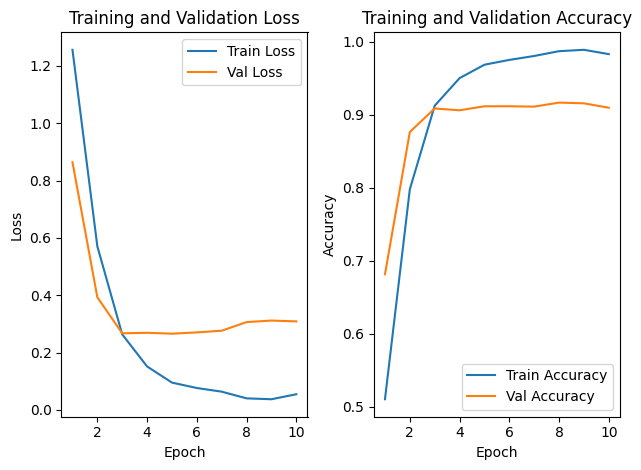

              precision    recall  f1-score   support

       anger       0.95      0.86      0.91       274
        fear       0.91      0.84      0.88       212
         joy       0.93      0.93      0.93       701
        love       0.81      0.83      0.82       175
     sadness       0.92      0.95      0.93       550
    surprise       0.74      0.85      0.79        81

    accuracy                           0.91      1993
   macro avg       0.88      0.88      0.88      1993
weighted avg       0.91      0.91      0.91      1993



In [41]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()


# Save
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/training_history_final.png")
plt.show()
plt.close()

# Load best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

# Evaluation
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=3))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_
            )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()

plt.savefig(f"{PLOTS_DIR}/confusion_matrix.png")
plt.close()